In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [2]:
disease_types = ['Pepper_Bacterial','Pepper_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Tomato_Bacterial',
                'Tomato_Curl_Virus','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_mosaic',
                'Tomato_Septoria_leaf_spot','Tomato_spider_mite','Tomato_Target_Spot']
data_dir = '/Users/michaellaraglione/Documents/GitHub/Capstone3/PlantVillage/'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(5)

,File,DiseaseID,Disease Type
0,Pepper_Bacterial/47fbd17d-c078-4465-8816-c675a...,0,Pepper_Bacterial
1,Pepper_Bacterial/42ef264d-f255-4674-885a-0921a...,0,Pepper_Bacterial
2,Pepper_Bacterial/435993b8-c7f7-47fd-85ad-bdb04...,0,Pepper_Bacterial
3,Pepper_Bacterial/1fca0f2b-857b-4cef-9218-42b1b...,0,Pepper_Bacterial
4,Pepper_Bacterial/9cee73cb-272f-4121-b82d-c8c2b...,0,Pepper_Bacterial


In [4]:
seed = 45
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,DiseaseID,Disease Type
3046,Potato_Early_blight/acff9d5e-4b38-4817-a239-93...,2,Potato_Early_blight
6803,Tomato_Curl_Virus/31945578-c927-474f-b807-1788...,6,Tomato_Curl_Virus
10112,Tomato_Early_blight/9b0106a7-eb90-4bb2-beec-6c...,7,Tomato_Early_blight
3126,Potato_Early_blight/4849de96-2e26-4c8d-8944-bd...,2,Potato_Early_blight
5008,Tomato_Bacterial/6c300ff6-c94d-4065-8354-73a14...,5,Tomato_Bacterial


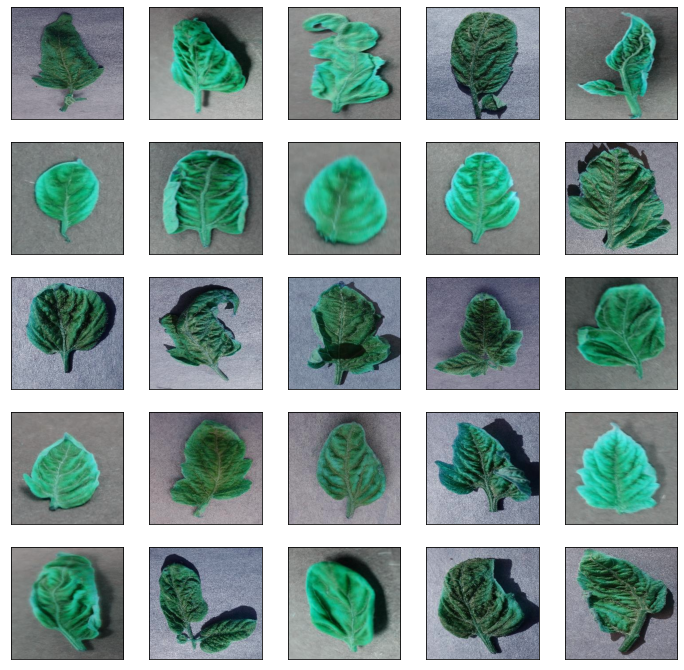

In [5]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('Tomato_Curl_Virus', 5, 5)

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)
validation_generator = datagen.flow_from_directory(
    data_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb",
    class_mode="categorical")

train_generator = datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical")

Found 20638 images belonging to 15 classes.
Found 16516 images belonging to 15 classes.


In [21]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=15, activation = 'softmax')])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 6)       168       
_________________________________________________________________
average_pooling2d_6 (Average (None, 127, 127, 6)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 16)      880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               7380600   
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

In [23]:
batch_size = 32
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator)

Epoch 1/30
517/517 [==============================] - 187s 361ms/step - loss: 0.0535 - accuracy: 0.9827 - val_loss: 0.1289 - val_accuracy: 0.9723
Epoch 2/30
517/517 [==============================] - 186s 360ms/step - loss: 0.0376 - accuracy: 0.9890 - val_loss: 0.2942 - val_accuracy: 0.9281
Epoch 3/30
517/517 [==============================] - 184s 356ms/step - loss: 0.0849 - accuracy: 0.9758 - val_loss: 0.1456 - val_accuracy: 0.9681
Epoch 4/30
517/517 [==============================] - 184s 356ms/step - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.1964 - val_accuracy: 0.9549
Epoch 5/30
517/517 [==============================] - 184s 356ms/step - loss: 0.0633 - accuracy: 0.9783 - val_loss: 0.2410 - val_accuracy: 0.9471
Epoch 6/30
517/517 [==============================] - 184s 355ms/step - loss: 0.0289 - accuracy: 0.9890 - val_loss: 0.2161 - val_accuracy: 0.9569
Epoch 7/30
517/517 [==============================] - 184s 355ms/step - loss: 0.0598 - accuracy: 0.9805 - val_loss: 0.1367 -

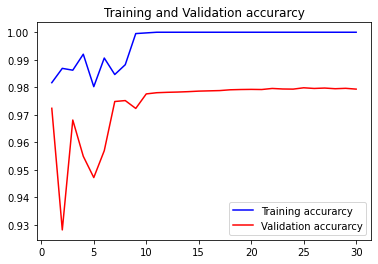

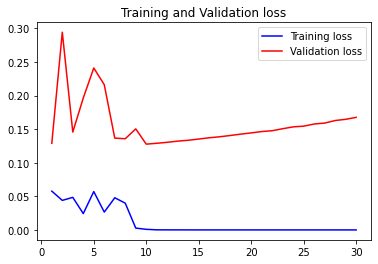

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])